## The raw data files and their format

While the rate of fatal road accidents has been decreasing steadily since the 80s, the past ten years have seen a stagnation in this reduction. Coupled with the increase in number of miles driven in the nation, the total number of traffic related-fatalities has now reached a ten year high and is rapidly increasing.

Per request of the US Department of Transportation, we are currently investigating how to derive a strategy to reduce the incidence of road accidents across the nation. By looking at the demographics of traﬃc accident victims for each US state, we find that there is a lot of variation between states. Now we want to understand if there are patterns in this variation in order to derive suggestions for a policy action plan. In particular, instead of implementing a costly nation-wide plan we want to focus on groups of states with similar profiles. How can we find such groups in a statistically sound way and communicate the result effectively?

To accomplish these tasks, we will make use of data wrangling, plotting, dimensionality reduction, and unsupervised clustering.

The data given to us was originally collected by the National Highway Traffic Safety Administration and the National Association of Insurance Commissioners.


In [1]:
import os
current_dir = os.getcwd() 
print(current_dir)

# List all files in this folder
file_list = os. listdir('.')
print(file_list)



C:\Users\hp\Desktop\Mahnoor's Work\Techcolab internship\Mini Project
['.ipynb_checkpoints', 'miles-driven.csv', 'Reducing Traffic Mortality.ipynb', 'road-accidents.csv']


## Read in and get an overview of the data
Next, we will orient ourselves to get to know the data with which we are dealing.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
accident = pd.read_csv('road-accidents.csv', comment ='#',sep='|')
accident.head()

,state,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
0,Alabama,18.8,39,30,80
1,Alaska,18.1,41,25,94
2,Arizona,18.6,35,28,96
3,Arkansas,22.4,18,26,95
4,California,12.0,35,28,89


## Textual Summary

In [4]:
accident.dtypes

state                    object
drvr_fatl_col_bmiles    float64
perc_fatl_speed           int64
perc_fatl_alcohol         int64
perc_fatl_1st_time        int64
dtype: object

In [5]:
accident.shape

(51, 5)

In [6]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   state                 51 non-null     object 
 1   drvr_fatl_col_bmiles  51 non-null     float64
 2   perc_fatl_speed       51 non-null     int64  
 3   perc_fatl_alcohol     51 non-null     int64  
 4   perc_fatl_1st_time    51 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.1+ KB


In [7]:
accident.describe()

,drvr_fatl_col_bmiles,perc_fatl_speed,perc_fatl_alcohol,perc_fatl_1st_time
count,51.000000,51.000000,51.000000,51.00000
mean,15.790196,31.725490,30.686275,88.72549
std,4.122002,9.633438,5.132213,6.96011
min,5.900000,13.000000,16.000000,76.00000
25%,12.750000,23.000000,28.000000,83.50000
50%,15.600000,34.000000,30.000000,88.00000
75%,18.500000,38.000000,33.000000,95.00000
max,23.900000,54.000000,44.000000,100.00000


In [8]:
accident.columns

Index(['state', 'drvr_fatl_col_bmiles', 'perc_fatl_speed', 'perc_fatl_alcohol',
       'perc_fatl_1st_time'],
      dtype='object')

In [9]:
df = list(accident.columns)
df

['state',
 'drvr_fatl_col_bmiles',
 'perc_fatl_speed',
 'perc_fatl_alcohol',
 'perc_fatl_1st_time']

In [10]:
df[1], df[4] = df[4], df[1]
df

['state',
 'perc_fatl_1st_time',
 'perc_fatl_speed',
 'perc_fatl_alcohol',
 'drvr_fatl_col_bmiles']

In [11]:
accident= accident[df]

In [12]:
accident.tail()

,state,perc_fatl_1st_time,perc_fatl_speed,perc_fatl_alcohol,drvr_fatl_col_bmiles
46,Virginia,88,19,27,12.7
47,Washington,86,42,33,10.6
48,West Virginia,87,34,28,23.8
49,Wisconsin,84,36,33,13.8
50,Wyoming,90,42,32,17.4


## Graphical Summary of Data

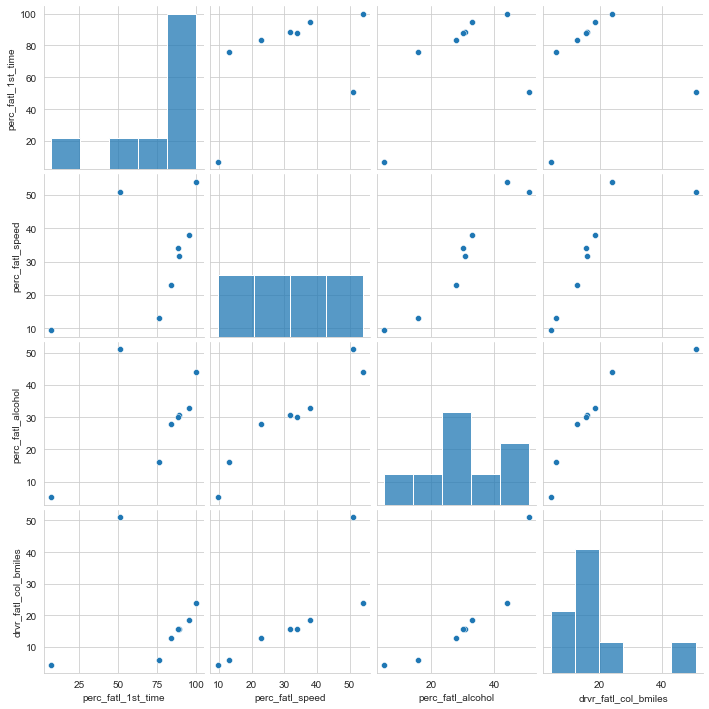

In [13]:
sns.set_style('whitegrid')
sns.pairplot(accident.describe())
plt.show()

## Quantify the association of features and accidents
We can already see some potentially interesting relationships between the target variable (the number of fatal accidents) and the feature variables (the remaining three columns).

To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:

- 0.2 = weak
- 0.5 = medium
- 0.8 = strong
- 0.9 = very strong

In [14]:
acc_association =accident.corr()
acc_association

,perc_fatl_1st_time,perc_fatl_speed,perc_fatl_alcohol,drvr_fatl_col_bmiles
perc_fatl_1st_time,1.000000,0.014066,-0.245455,-0.017942
perc_fatl_speed,0.014066,1.000000,0.286244,-0.029080
perc_fatl_alcohol,-0.245455,0.286244,1.000000,0.199426
drvr_fatl_col_bmiles,-0.017942,-0.029080,0.199426,1.000000


## Fit a multivariate linear regression
From the correlation table, we see that the amount of fatal accidents is most strongly correlated with alcohol consumption (first row). But in addition, we also see that some of the features are correlated with each other, for instance, speeding and alcohol consumption are positively correlated. We, therefore, want to compute the association of the target with each feature while adjusting for the effect of the remaining features. This can be done using multivariate linear regression.
Both the multivariate regression and the correlation measure how strongly the features are associated with the outcome (fatal accidents). When comparing the regression coefficients with the correlation coefficients, we will see that they are slightly different. The reason for this is that the multiple regression computes the association of a feature with an outcome, given the association with all other features, which is not accounted for when calculating the correlation coefficients.
 A particularly interesting case is when the correlation coefficient and the regression coefficient of the same feature have opposite signs. How can this be? For example, when a feature A is positively correlated with the outcome Y but also positively correlated with a different feature B that has a negative effect on Y, then the indirect correlation (A->B->Y) can overwhelm the direct correlation (A->Y). In such a case, the regression coefficient of feature A could be positive, while the correlation coefficient is negative. This is sometimes called a masking relationship. Let’s see if the multivariate regression can reveal such a phenomenon.

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
X = accident[['perc_fatl_1st_time','perc_fatl_speed','perc_fatl_alcohol']]
y = accident['drvr_fatl_col_bmiles']


In [17]:
lr = LinearRegression()
lr_fit = lr.fit(X,y)

In [18]:
coef = lr_fit.coef_
coef

array([ 0.02473301, -0.04180041,  0.19086404])

### Perform PCA on standardized data
We have learned that alcohol consumption is weakly associated with the number of fatal accidents across states. This could lead us to conclude that alcohol consumption should be a focus for further investigations and maybe strategies should divide states into high versus low alcohol consumption in accidents. But there are also associations between alcohol consumptions and the other two features, so it might be worth trying to split the states in a way that accounts for all three features.
One way of clustering the data is to use PCA to visualize data in reduced dimensional space where we can try to pick up patterns by eye. PCA uses the absolute variance to calculate the overall variance explained for each principal component, so it is important that the features are on a similar scale (unless we would have a particular reason that one feature should be weighted more).
We'll use the appropriate scaling function to standardize the features to be centered with mean 0 and scaled with standard deviation 1.

- Scaling the data
- Transform the data 
- Apply pca 
- Visualize

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [20]:
scaler = StandardScaler()
scaled = scaler.fit_transform(X)

In [21]:
pca = PCA()
# fit 
pca.fit(scaled)

PCA()

## VISUALIZING

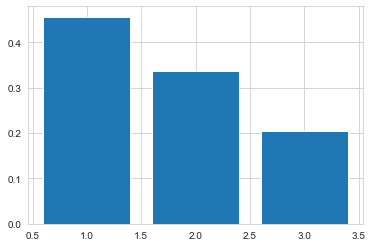

In [22]:
plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
plt.show()

## Find clusters of similar states in the data
It was not entirely clear from the PCA scatter plot how many groups in which the states cluster. To assist with identifying a reasonable number of clusters, we can use KMeans clustering by creating a scree plot and finding the "elbow", which is an indication of when the addition of more clusters does not add much explanatory power.

In [23]:
from sklearn.cluster import KMeans

C:\Users\hp\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


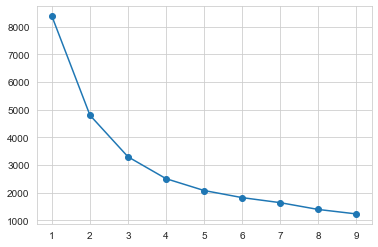

In [24]:
# range
kr = range(1,10)
interia = []
for i in kr:
    km = KMeans(n_clusters=i,random_state=8)
    km.fit(X)
    # append 
    interia.append(km.inertia_)
    
plt.plot(kr, interia, marker ='o')

## Visualize the first two principal components
The first two principal components enable visualization of the data in two dimensions while capturing a high proportion of the variation (79%) from all three features: speeding, alcohol influence, and first-time accidents. This enables us to use our eyes to try to discern patterns in the data with the goal to find groups of similar states. Although clustering algorithms are becoming increasingly efficient, human pattern recognition is an easily accessible and very efficient method of assessing patterns in data.
We will create a scatter plot of the first principle components and explore how the states cluster together in this visualization.

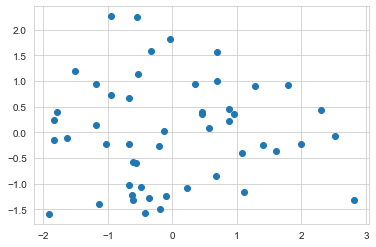

In [25]:
pca = PCA(n_components=2)
pca_tran = pca.fit_transform(scaled)
pca_1 = pca_tran[:,0]
pca_2 = pca_tran[:,1]


plt.scatter(pca_1,pca_2)

## KMeans to visualize clusters in the PCA scatter plot
Since there wasn't a clear elbow in the scree plot, assigning the states to either two or three clusters is a reasonable choice, and we will resume our analysis using three clusters. Let's see how the PCA scatter plot looks if we color the states according to the cluster to which they are assigned.

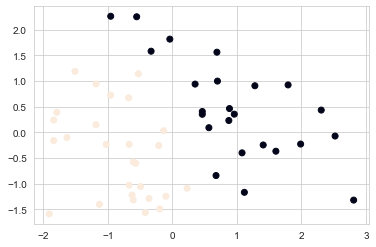

In [26]:
km = KMeans(n_clusters=2, random_state=5)
km_tran = km.fit_transform(scaled)
km_1 = pca_tran[:,0]
km_2 = pca_tran[:,1]


plt.scatter(km_1,km_2, c = km.labels_)

## Visualize the feature differences between the clusters
Thus far, we have used both our visual interpretation of the data and the KMeans clustering algorithm to reveal patterns in the data, but what do these patterns mean?
Remember that the information we have used to cluster the states into three distinct groups are the percentage of drivers speeding, under alcohol influence and that has not previously been involved in an accident. We used these clusters to visualize how the states group together when considering the first two principal components. This is good for us to understand structure in the data, but not always easy to understand, especially not if the findings are to be communicated to a non-specialist audience.
A reasonable next step in our analysis is to explore how the three clusters are different in terms of the three features that we used for clustering. Instead of using the scaled features, we return to using the unscaled features to help us interpret the differences.

<AxesSubplot:xlabel='measurement', ylabel='percent'>

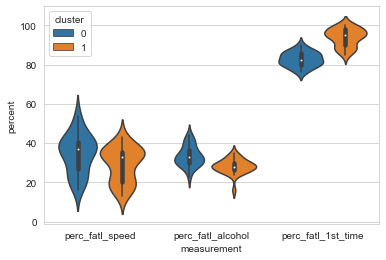

In [27]:
accident['cluster'] = km.labels_

# Reshape the DataFrame to the long format
melt_car = pd.melt(accident, id_vars='cluster', var_name='measurement',
                  value_name="percent", value_vars=["perc_fatl_speed", "perc_fatl_alcohol", "perc_fatl_1st_time"])

# Create a violin plot splitting and coloring the results according to the km-clusters
sns.violinplot(data=melt_car, x="measurement", y="percent", hue="cluster")

## Compute the number of accidents within each cluster
Now it is clear that different groups of states may require different interventions. Since resources and time are limited, it is useful to start off with an intervention in one of the three groups first. Which group would this be? To determine this, we will include data on how many miles are driven in each state, because this will help us to compute the total number of fatal accidents in each state. Data on miles driven is available in another tab-delimited text file. We will assign this new information to a column in the DataFrame and create a violin plot for how many total fatal traffic accidents there are within each state cluster.

In [31]:
miles = pd.read_csv('miles-driven.csv',sep='|')
miles.head()

,state,million_miles_annually
0,Alabama,64914
1,Alaska,4593
2,Arizona,59575
3,Arkansas,32953
4,California,320784


In [35]:
accident_miles = accident.merge(miles,on ='state')
# number of driver in fatal accident
accident_miles['num_fatal'] = accident_miles['drvr_fatl_col_bmiles']/1000 *accident_miles['million_miles_annually']
accident_miles.head()


,state,perc_fatl_1st_time,perc_fatl_speed,perc_fatl_alcohol,drvr_fatl_col_bmiles,cluster,million_miles_annually,num_fatal
0,Alabama,80,39,30,18.8,0,64914,1220.3832
1,Alaska,94,41,25,18.1,1,4593,83.1333
2,Arizona,96,35,28,18.6,1,59575,1108.0950
3,Arkansas,95,18,26,22.4,1,32953,738.1472
4,California,89,35,28,12.0,1,320784,3849.4080


<AxesSubplot:xlabel='cluster', ylabel='num_fatal'>

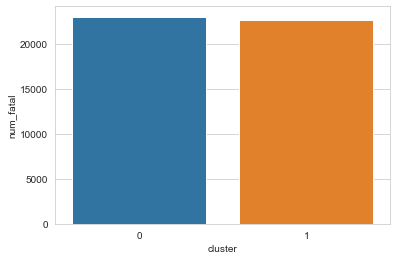

In [40]:
sns.barplot(x='cluster', y ='num_fatal', ci =None, data=accident_miles, estimator=sum)

##  Make a decision when there is no clear right choice
As we can see, there is no obvious correct choice regarding which cluster is the most important to focus on. Yet, we can still argue for a certain cluster and motivate this using our findings above. Which cluster do you think should be a focus for policy intervention and further investigation?

In [42]:
## Which cluster 
cluster_num = 0
